In [115]:
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import wandb

from ipywidgets import IntSlider, interact
from matplotlib import animation, rc
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from scipy import ndimage
from scipy.ndimage import zoom
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras import Input, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (BatchNormalization, Conv3D, Dense,
                                     Dropout, GlobalAveragePooling3D,
                                     MaxPool3D)
from keras.optimizers import Adam
from wandb.keras import WandbCallback

import keras_applications_3d as ka3d
from keras_applications_3d import vgg16, vgg19, resnet, resnet_v2, densenet

import splitfolders
import nibabel as nib

Data loading and preprocessing

In [116]:
data_dir = "data/"
nb_classes = 4


In [117]:
file = "./lib/n_mmni_fADNI_002_S_0295_1.5T_t1w.nii.gz"
def read_nifti_file(filepath):
    return nib.load(filepath)   
print(read_nifti_file(file).shape)


(181, 217, 181)


Class Distribution

In [118]:
# TODO - functions to load data and labels : files are in /lib folder and they are names as follows: [class][id][mask or not].nii.gz, for each mri image there is a mask image with the same id and class and we need to multiply them to get the final masked image 


def arrange_data():
    if not os.path.exists("./lib/AD"):
        os.mkdir("./lib/AD")
    if not os.path.exists("./lib/CN"):
        os.mkdir("./lib/CN")
    if not os.path.exists("./lib/PMCI"):
        os.mkdir("./lib/PMCI")
    if not os.path.exists("./lib/SMCI"):
        os.mkdir("./lib/SMCI")
    for file in os.listdir("./lib"):
        if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
            if file.startswith("AD"):
                os.rename("./lib/"+file, "./lib/AD/"+file)
            elif file.startswith("CN"):
                os.rename("./lib/"+file, "./lib/CN/"+file)
            elif file.startswith("PMCI"):
                os.rename("./lib/"+file, "./lib/PMCI/"+file)
            elif file.startswith("SMCI"):
                os.rename("./lib/"+file, "./lib/SMCI/"+file)
arrange_data()

# use splitfolders library to split data into train, validation and test folders
if not os.path.exists("./data"):
    splitfolders.ratio('./lib', output="./data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values
  
     

In [119]:
# Create train set generator for .nii.gz files

train_set = []
train_labels = []
for file in os.listdir("./data/train/AD"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        train_set.append("./data/train/AD/"+file)
        train_labels.append(0)
for file in os.listdir("./data/train/CN"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        train_set.append("./data/train/CN/"+file)
        train_labels.append(1)
for file in os.listdir("./data/train/PMCI"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        train_set.append("./data/train/PMCI/"+file)
        train_labels.append(2)
for file in os.listdir("./data/train/SMCI"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        train_set.append("./data/train/SMCI/"+file)
        train_labels.append(3)
        
# Create validation set generator for .nii.gz files
val_set = []
val_labels = []
for file in os.listdir("./data/val/AD"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        val_set.append("./data/val/AD/"+file)
        val_labels.append(0)
for file in os.listdir("./data/val/CN"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        val_set.append("./data/val/CN/"+file)
        val_labels.append(1)
for file in os.listdir("./data/val/PMCI"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        val_set.append("./data/val/PMCI/"+file)
        val_labels.append(2)
for file in os.listdir("./data/val/SMCI"):
    if file.endswith(".nii.gz") and not file.endswith("-mask.nii.gz"):
        val_set.append("./data/val/SMCI/"+file)
        val_labels.append(3)
        
print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
    

Train set size:  572
Validation set size:  146


Build Train and Validation Datasets

In [120]:
# TODO - build train, validation, test sets

Data Augmentation

Les données originales sont représentées sous la forme de tenseurs tridimensionnels avec des dimensions (samples, height, width, depth). Cependant, afin de permettre l'utilisation de convolutions 3D sur ces données, nous devons ajouter une dimension supplémentaire à nos tenseurs. Cette dimension est ajoutée à l'axe 4, qui représente le nombre de canaux. En général quand on traite des images 2D en couleurs on a 3 canaux pour le RGB, ici on traite des images 3D en pseudo NB. Donc en ajoutant une dimension, les données sont transformées en tenseurs de forme (samples, height, width, depth, 1)

In [121]:
# TODO - Add a dimension to the data to make it 4D (for the channel)
def dim_augmentation(data):
    data = np.expand_dims(data, axis=3)
    return data
height, width, depth, _ = dim_augmentation(read_nifti_file(train_set[0]).get_fdata()).shape
print("Data shape: ", height, width, depth, _)

def get_HC(irm):
    hc1 = irm[40:80, 90:130, 40:80]
    hc2 = irm[100:140, 90:130, 40:80]
    return hc1, hc2

Data shape:  181 217 181 1


In [122]:
from keras.utils import Sequence

class NiiSequence(Sequence):
    def __init__(self, file_paths, batch_size):
        self.file_paths = file_paths
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Charger et prétraiter les données
        batch_data = [self.load_and_preprocess(path) for path in batch_paths]

        # Convertir la liste en un tableau NumPy
        batch_data = np.array(batch_data)

        # Créer les étiquettes correspondantes
        batch_labels = [self.extract_label(path) for path in batch_paths]

        # Convertir les étiquettes en tableau NumPy et les encoder en one-hot
        batch_labels = np.eye(nb_classes)[batch_labels]

        return batch_data, batch_labels
        
    def extract_label(self, file_path):
        # Adapté à votre structure de répertoire
        class_name = os.path.basename(os.path.dirname(file_path))
        # Convertir le nom de la classe en une représentation one-hot si nécessaire
        label = {"AD": 0, "CN": 1, "PMCI": 2, "SMCI": 3}[class_name]
        return label

    def load_and_preprocess(self, file_path):
        data = read_nifti_file(file_path).get_fdata()
        
        # data = get_HC(data)[0]
        #irm[:,50:70,:]
        # data = data[:,50:70,:]
        
        # data = 6 layers from 40 to 90 with step 10 :  [30:155,40,10:150] - [30:155,50,10:150] - [30:155,60,10:150] - [30:155,70,10:150] - [30:155,80,10:150] - [30:155,90,10:150] 
        
        mri = np.zeros((125, 150, 32))
        for k in range(32):
            mri[:,:,k] = data[30:155,40+k*2,10:160]
    
        data = dim_augmentation(mri)

        return data

# Exemple d'utilisation
batch_size = 2

train_sequence = NiiSequence(train_set, batch_size)
val_sequence = NiiSequence(val_set, batch_size)




Scan Visualization

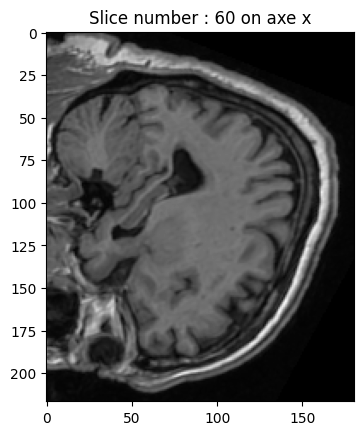

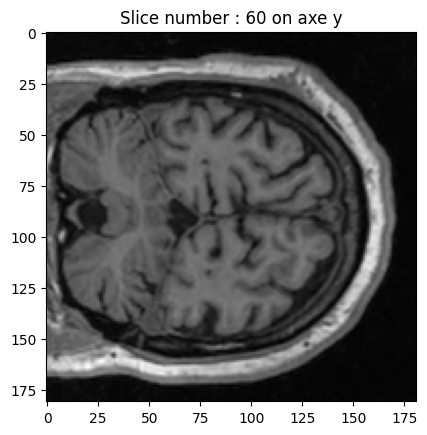

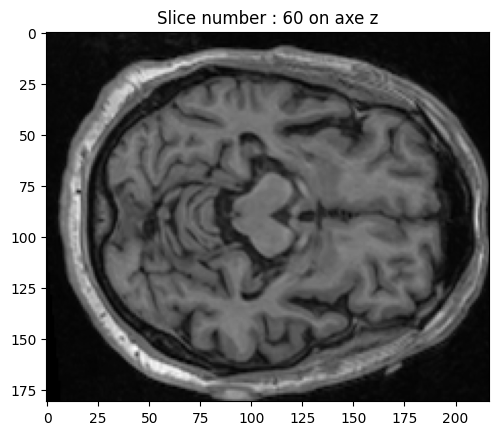

In [123]:
# MRI images are composed by many slices, build a montage of the them

def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()
    
img = read_nifti_file(train_set[0])
show_2D(img.get_fdata(), 60, "x")
show_2D(img.get_fdata(), 60, "y")
show_2D(img.get_fdata(), 60, "z")

Imbalanced Data

{'AD': 191, 'CN': 227, 'PMCI': 171, 'SMCI': 129}


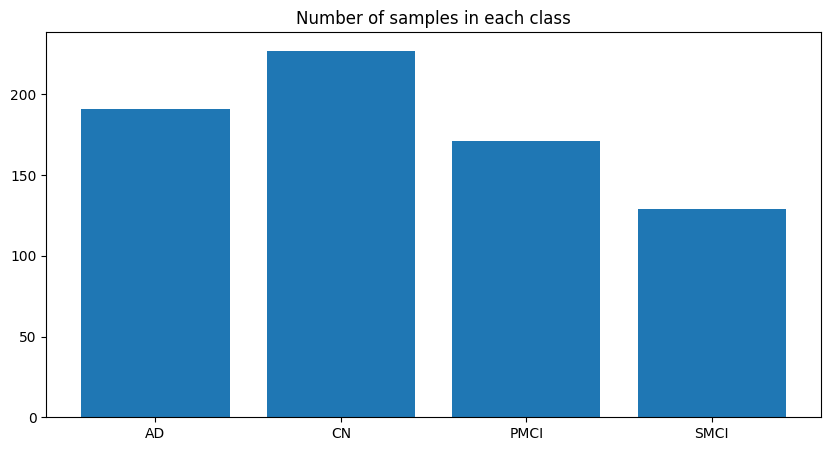

In [124]:
## Calculate number of samples in each class.
input_folder = 'lib'
class_counts = dict()
class_names = ["AD", "CN", "PMCI", "SMCI"]
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()

3D Convolutional Neural Network

In [125]:
def get_model(height=181, width=217, depth=181):
    """Build a 3D convolutional neural network model."""
    
    net = vgg19.VGG19(
        input_shape=(height, width, depth, 1),
        include_top=False,
        weights=None,
        classes=nb_classes,
        base_channel=4
    )
    
    x = net.layers[-1].output
    x = GlobalAveragePooling3D()(x)    
    x = Dense(units=64, activation='relu')(x)
    x = Dense(units=32, activation='relu')(x)
    outputs = Dense(units=nb_classes, activation='softmax')(x)
    
    return Model(net.inputs, outputs, name='3D-ResNet50')


# Build model.
model = get_model(height=125, width=150, depth=32)
model.summary()

Model: "3D-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 125, 150, 32, 1   0         
                             )]                                  
                                                                 
 block1_conv1 (Conv3D)       (None, 125, 150, 32, 4)   112       
                                                                 
 block1_conv2 (Conv3D)       (None, 125, 150, 32, 4)   436       
                                                                 
 block1_pool (MaxPooling3D)  (None, 62, 75, 16, 4)     0         
                                                                 
 block2_conv1 (Conv3D)       (None, 62, 75, 16, 8)     872       
                                                                 
 block2_conv2 (Conv3D)       (None, 62, 75, 16, 8)     1736      
                                                       

Model training

In [126]:
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['acc'],
)
print(train_sequence[0][0].shape)
print(train_sequence[1][1].shape)

model.fit(
    train_sequence,
    validation_data=val_sequence,
    epochs=10,
)

(2, 125, 150, 32, 1)
(2, 4)
Epoch 1/10
 27/286 [=>............................] - ETA: 4:14 - loss: 1.4181 - acc: 0.5185

Visualizing Training History

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['acc', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [ ]:
# TODO - Evaluate the model on the test set